In [12]:
from features import map_sequences_to_features
from aux import load_files, train_validate_split, nfolds_cross_validate, tuples_to_matrices
from aux import FILES as labels_fasta 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from scipy import interp

import numpy as np
from matplotlib import pyplot as plt

import itertools
from itertools import cycle


In [2]:
def grid_search():
    file_data = load_files()
    feature_data = map_sequences_to_features(file_data)
    X, Y = tuples_to_matrices(feature_data)

    parameters = { 
        "n_estimators": [200, 300, 400, 450],
        "criterion": ["gini"],
        "n_jobs": [-1]
    }

    estimator = RandomForestClassifier()
    clf = GridSearchCV(estimator, parameters, cv=5)
    clf.fit(X,Y)
    print(clf.best_score_)
    print(clf.best_params_)
    print(clf.cv_results_["mean_test_score"])
    print(clf.cv_results_["params"])

    

In [3]:
def main():
    tv_split = 0.3

    file_data = load_files()
    
    feature_data, keys = map_sequences_to_features(file_data)
    np.random.shuffle(feature_data)
    

    train, validate = train_validate_split(tv_split, feature_data)
    
    parameters = { 
        "n_estimators": 400,
        "criterion": "gini",
        "n_jobs": -1
    }


    # X, Y = tuples_to_matrices(feature_data)
    model = RandomForestClassifier(**parameters)
#     model = XGBClassifier()
    model = OneVsRestClassifier(model)
    # model = OneVsRestClassifier(LinearSVC())

    model.fit(*tuples_to_matrices(train))
    valid_acc = model.score(*tuples_to_matrices(validate))
    
    # def run(train, validate):
    #    model.fit(*tuples_to_matrices(train))
    #    return model.score(*tuples_to_matrices(validate))
    #
    # valid_acc = nfolds_cross_validate(5, feature_data, run)
    
    return model, train, validate, valid_acc, keys
    

In [4]:
model, train, validate, acc, keys = main()

['aromaticity', 'end_letter_A', 'end_letter_C', 'end_letter_D', 'end_letter_E', 'end_letter_F', 'end_letter_G', 'end_letter_H', 'end_letter_I', 'end_letter_J', 'end_letter_K', 'end_letter_L', 'end_letter_M', 'end_letter_N', 'end_letter_O', 'end_letter_P', 'end_letter_Q', 'end_letter_R', 'end_letter_S', 'end_letter_T', 'end_letter_U', 'end_letter_V', 'end_letter_W', 'end_letter_Y', 'end_letter_Z', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'isoelectric', 'mol_weight', 'seq_length', 'start_letter_A', 'start_letter_C', 'start_letter_D', 'start_letter_E', 'start_letter_F', 'start_letter_G', 'start_letter_H', 'start_letter_I', 'start_letter_J', 'start_letter_K', 'start_letter_L', 'start_letter_M', 'start_letter_N', 'start_letter_O', 'start_letter_P', 'start_letter_Q', 'start_letter_R', 'start_letter_S', 'start_letter_T', 'start_letter_U

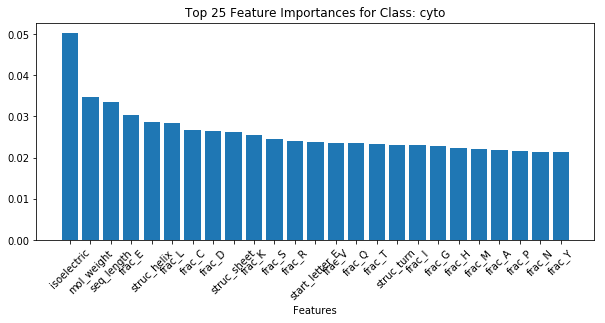

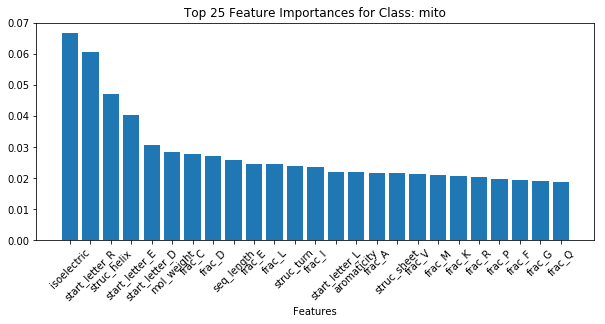

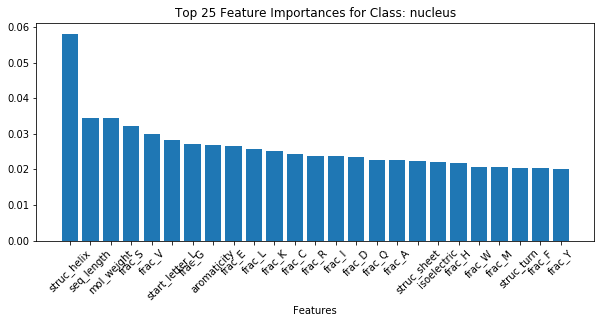

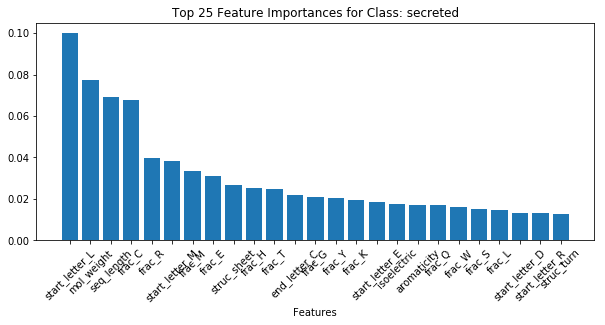

In [5]:
def one_vs_many_graphs(model):
    k = keys[:]
    for i, est in enumerate(model.estimators_):
        l = labels_fasta[model.classes_[i]].replace(".fasta","")
        fi, k_s = list(zip(*sorted(list(zip(est.feature_importances_, keys)), key=lambda x:x[0], reverse=True)))
        plt.figure(figsize=(10,4))
        plt.bar(k_s[:25], fi[:25])
        plt.xticks(rotation=45)
        plt.xlabel("Features")
        plt.title("Top 25 Feature Importances for Class: {}".format(l))
        plt.show()
one_vs_many_graphs(model)

In [6]:
len(keys)

75

In [7]:
def plot_roc_auc(y_test, y_score, label_names):
    n_classes = 4
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class classifier')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[515  38 303  30]
 [ 69 245  43  21]
 [263  26 708  20]
 [ 38  20  18 409]]


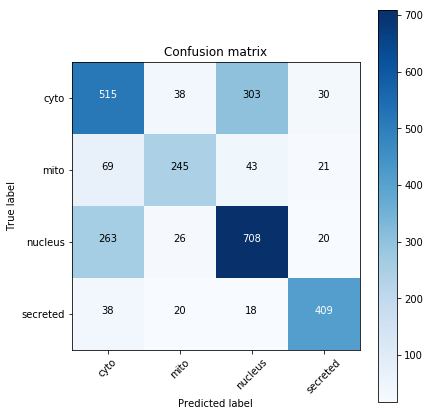

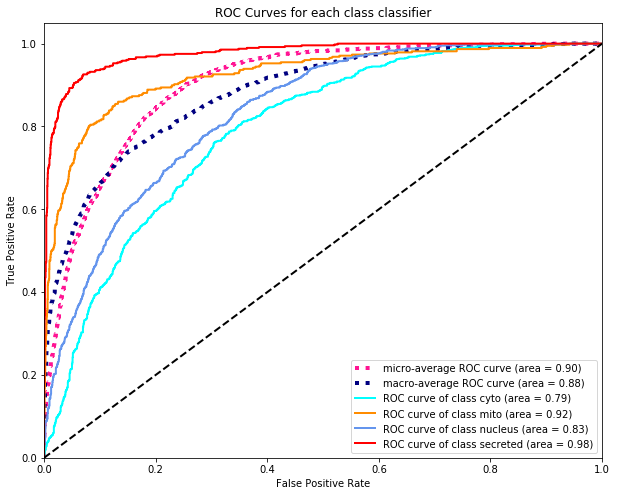

In [9]:


label_names = [l.replace(".fasta","") for l in labels_fasta]
X_val, Y_val = tuples_to_matrices(validate)
Y_predict_proba = model.predict_proba(X_val)
Y_predict = model.predict(X_val)
cm = confusion_matrix(Y_val, Y_predict)

Y_val_bin = label_binarize(Y_val, classes=[0, 1, 2, 3])
Y_pred_bin = label_binarize(Y_predict, classes=[0, 1, 2, 3])

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, label_names)

plot_roc_auc(Y_val_bin, Y_predict_proba, label_names)

In [10]:
def find_mislabelled(sequences, pred, gold,  true_label, classified_as):
    samples = []
    for i, s in enumerate(sequences):
        if (gold[i] == true_label).all() and (pred[i] == classified_as).all():
            samples.append((s,i))
    return samples
nuke = 3
cyto = 1
find_mislabelled(X_val, Y_predict, Y_val, nuke, cyto )

[(array([9.70654628e-02, 5.00000000e-02, 0.00000000e+00, 5.00000000e-02,
         0.00000000e+00, 0.00000000e+00, 5.00000000e-02, 1.50000000e-01,
         1.50000000e-01, 0.00000000e+00, 1.50000000e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00000000e-02,
         5.00000000e-02, 1.50000000e-01, 0.00000000e+00, 5.00000000e-02,
         0.00000000e+00, 1.00000000e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 3.61173815e-02, 2.93453725e-02, 5.64334086e-02,
         7.22347630e-02, 2.93453725e-02, 4.06320542e-02, 3.38600451e-02,
         4.96613995e-02, 8.35214447e-02, 1.42212190e-01, 9.02934537e-03,
         5.19187359e-02, 6.77200903e-02, 3.83747178e-02, 6.09480813e-02,
         5.64334086e-02, 2.93453725e-02, 4.51467269e-02, 1.58013544e-02,
         5.19187359e-02, 8.60467529e+00, 5.18511620e+04, 4.43000000e+02,
         1.50000000e-01, 1.00000000e-01, 0.00000000e+00, 5.00000000e-02,
         5.00000000e-02, 0.00000000e+00, 0.00000000

In [11]:
plt.figure(figsize=(20,8))
plt.bar(keys, height=model.feature_importances_)
plt.xticks(rotation=45)
plt.show()

AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_importances_'

### Dont forget ablation study

In [4]:
from run_model import run_test_models

In [5]:
clfs, train_val, test = run_test_models()

['aromaticity', 'end_letter_A', 'end_letter_C', 'end_letter_D', 'end_letter_E', 'end_letter_F', 'end_letter_G', 'end_letter_H', 'end_letter_I', 'end_letter_J', 'end_letter_K', 'end_letter_L', 'end_letter_M', 'end_letter_N', 'end_letter_O', 'end_letter_P', 'end_letter_Q', 'end_letter_R', 'end_letter_S', 'end_letter_T', 'end_letter_U', 'end_letter_V', 'end_letter_W', 'end_letter_Y', 'end_letter_Z', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'isoelectric', 'mol_weight', 'seq_length', 'start_letter_A', 'start_letter_C', 'start_letter_D', 'start_letter_E', 'start_letter_F', 'start_letter_G', 'start_letter_H', 'start_letter_I', 'start_letter_J', 'start_letter_K', 'start_letter_L', 'start_letter_M', 'start_letter_N', 'start_letter_O', 'start_letter_P', 'start_letter_Q', 'start_letter_R', 'start_letter_S', 'start_letter_T', 'start_letter_U

In [6]:
clfs

[GridSearchCV(cv=5, error_score='raise',
        estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'n_estimators': [50, 100, 200, 400, 450], 'learning_rate': [0.5, 1, 2]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0), GridSearchCV(cv=5, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'n_estimators': [2

In [14]:
def get_results(classifier_lists, test):
    X, Y = tuples_to_matrices(test)
    for i, clf in enumerate(classifier_lists):
        pred = clf.predict(X)
        predic_proba = clf.predict_proba(X)
        print("Model", i)
        print("Score, ",clf.best_score_)
        print("Params", clf.best_params_)
        print("Mean Test Score ", clf.cv_results_["mean_test_score"])
        
#         print("F1: ", f1_score(Y, pred))
        print("AUC: " )

In [15]:
get_results(clfs, test)

Model 0
Score,  0.6306587150989428
Params {'learning_rate': 0.5, 'n_estimators': 100}
Mean Test Score  [0.62320412 0.63065872 0.62794795 0.62374627 0.6188669  0.60599078
 0.61276769 0.61114123 0.6074817  0.60612632 0.44551369 0.44551369
 0.44551369 0.44551369 0.44551369]
AUC: 
Model 1
Score,  0.6780970452697208
Params {'criterion': 'gini', 'n_estimators': 450, 'n_jobs': -1}
Mean Test Score  [0.67172676 0.67714828 0.67782597 0.67809705]
AUC: 
Model 2
Score,  0.6791813499593385
Params {'estimator__criterion': 'gini', 'estimator__n_estimators': 300, 'estimator__n_jobs': -1}
Mean Test Score  [0.67660613 0.67918135 0.6786392  0.67918135]
AUC: 


In [19]:
model_and_grid = [(AdaBoostClassifier(),{ 
        "n_estimators": [ 200, 300],
        "learning_rate": [ 0.25,],
    })]
def run_test_models():
    tv_split = 0.2
    file_data = load_files()
    feature_data, keys = map_sequences_to_features(file_data)
    np.random.shuffle(feature_data)
    
    train_and_validate, test = train_validate_split(tv_split, feature_data)
    X, Y = tuples_to_matrices(train_and_validate)

    fitted_models = []
    for model, grid in model_and_grid:
        print(model)
        clf = GridSearchCV(model, grid, cv=5)
        clf.fit(X,Y)
        fitted_models.append(clf)
    return fitted_models, train_and_validate, test
clfAda, tvAda, TestAda= run_test_models()



['aromaticity', 'end_letter_A', 'end_letter_C', 'end_letter_D', 'end_letter_E', 'end_letter_F', 'end_letter_G', 'end_letter_H', 'end_letter_I', 'end_letter_J', 'end_letter_K', 'end_letter_L', 'end_letter_M', 'end_letter_N', 'end_letter_O', 'end_letter_P', 'end_letter_Q', 'end_letter_R', 'end_letter_S', 'end_letter_T', 'end_letter_U', 'end_letter_V', 'end_letter_W', 'end_letter_Y', 'end_letter_Z', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'isoelectric', 'mol_weight', 'seq_length', 'start_letter_A', 'start_letter_C', 'start_letter_D', 'start_letter_E', 'start_letter_F', 'start_letter_G', 'start_letter_H', 'start_letter_I', 'start_letter_J', 'start_letter_K', 'start_letter_L', 'start_letter_M', 'start_letter_N', 'start_letter_O', 'start_letter_P', 'start_letter_Q', 'start_letter_R', 'start_letter_S', 'start_letter_T', 'start_letter_U

In [20]:
get_results(clfAda, TestAda)

Model 0
Score,  0.6318785578747628
Params {'learning_rate': 0.25, 'n_estimators': 200}
Mean Test Score  [0.63187856 0.63187856]
AUC: 
